In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Importing necessary
import torch
from torchvision import transforms
from torchvision import datasets
import pandas as pd
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np

In [ ]:
main_dir="/content/drive/MyDrive/apple_orange/apple2orange"
train_data={"image1":[],
       "image2":[]}
test_data={"image1":[],
       "image2":[]}
for category in os.listdir(main_dir):
  if category=="trainA":
    train_data["image1"]=os.listdir(os.path.join(main_dir, category))
    for i in range(len(train_data["image1"])):
      train_data["image1"][i]=os.path.join(os.path.join(main_dir, category), train_data["image1"][i])
  elif category=="trainB":
    train_data["image2"]=os.listdir(os.path.join(main_dir, category))
    for i in range(len(train_data["image2"])):
      train_data["image2"][i]=os.path.join(os.path.join(main_dir, category), train_data["image2"][i])
  elif category=="testA":
    test_data["image1"]=os.listdir(os.path.join(main_dir, category))
    for i in range(len(test_data["image1"])):
      test_data["image1"][i]=os.path.join(os.path.join(main_dir, category), test_data["image1"][i])
  elif category=="testB":
    test_data["image2"]=os.listdir(os.path.join(main_dir, category))
    for i in range(len(test_data["image2"])):
      test_data["image2"][i]=os.path.join(os.path.join(main_dir, category), test_data["image2"][i])


In [ ]:
print(len(train_data["image1"]))
print(len(train_data["image2"]))

995
1019


In [ ]:
import albumentations
from albumentations.pytorch import ToTensorV2
train_transform=albumentations.Compose([
    albumentations.Resize(256, 256),
    # albumentations.HorizontalFlip(p=0.5),
    # albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
    ToTensorV2()

], additional_targets={"image1": "image"} )

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data, transform):
    super().__init__()
    self.data=data
    self.transform=transform

  def __len__(self):
    return max(len(self.data["image1"]), len(self.data["image2"]))

  def __getitem__(self, index):
    image1=self.data["image1"][index%len(self.data["image1"])]
    image2=self.data["image2"][index%len(self.data["image2"])]
    image1=np.array(Image.open(image1).convert("RGB"))
    image2=np.array(Image.open(image2).convert("RGB"))
    if self.transform is not None:
      augmented_images=self.transform(image=image1, image1=image2)
      image1=augmented_images["image"]
      image2=augmented_images["image1"]
    image1=image1.float()
    image2=image2.float()
    image1/=255
    image2/=255
    return image1, image2



In [ ]:
data_train=MyDataset(train_data, train_transform)
data_test=MyDataset(test_data, train_transform)

In [ ]:
train_loader=DataLoader(data_train, batch_size=4, shuffle=True)

In [ ]:
#Creating convblock for Generator
class blockdown(nn.Module):
  def __init__(self, filters_in, filters_out, ken_size, stride, pad, relu="yes"):
    super().__init__()
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=ken_size, stride=stride, padding=pad, padding_mode="reflect"),
        nn.InstanceNorm2d(filters_out),
    )
    self.relu=relu

  def forward(self, x):
    x=self.block1(x)
    if self.relu=="yes":
      x=nn.ReLU(inplace=True)(x)
    return x

In [ ]:
#Creating upsampling blocks for Generator
class blockup(nn.Module):
  def __init__(self, filters_in, filters_out, ken_size, stride):
    super().__init__()
    self.block=nn.Sequential(
        nn.ConvTranspose2d(in_channels=filters_in, out_channels=filters_out, kernel_size=ken_size, stride=stride, padding=1, output_padding=1),
        nn.InstanceNorm2d(filters_out),
        nn.ReLU(inplace=True)
    )
  def forward(self, x):
    x=self.block(x)

    return x

In [ ]:
class Residualblock(nn.Module):
  def __init__(self, filters):
    super().__init__()
    self.block=nn.Sequential(
        blockdown(filters, filters, 3, 1, 1),
        blockdown(filters, filters, 3, 1, 1, "No")
    )
  def forward(self, x):
    return x+self.block(x)

In [ ]:

class Generator(nn.Module):
  def __init__(self, filters, no_res):
    super().__init__()
    self.num=no_res
    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=filters, out_channels=64, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
        nn.ReLU(inplace=True)

    )
    self.downblock1=blockdown(64, 128, 3, 2, 1)
    self.downblock2=blockdown(128, 256, 3, 2, 1)
    self.blockup1=blockup(256, 128, 3, 2)
    self.blockup2=blockup(128, 64, 3, 2)
    self.residual=Residualblock(256)

    self.last=nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3, padding_mode="reflect")




  def forward(self, x):
    x=self.block1(x)
    x=self.downblock1(x)
    x=self.downblock2(x)
    for i in range(self.num):
      x=self.residual(x)
    x=self.blockup1(x)
    x=self.blockup2(x)
    x=self.last(x)
    x=torch.tanh(x)

    return x


In [ ]:
loss_g=nn.BCELoss().to(device)
loss_d=nn.L1Loss().to(device)

In [ ]:
#Creating convblock for Discriminator
class dconvblock(nn.Module):
  def __init__(self, filters_in, filters_out, stride):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=4, stride=stride, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(filters_out),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.block(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, filters_in):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels=filters_in, out_channels=64, kernel_size=4, stride=2, padding_mode="reflect"),
        nn.LeakyReLU(0.2)
    )
    self.block1=dconvblock(64, 128, 2)
    self.block2=dconvblock(128, 256, 2)
    self.block3=dconvblock(256, 512, 1)
    self.block4=nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
    )
    # self.sigmoid=torch.sigmoid()

  def forward(self, x):
    x=self.block(x)
    x=self.block1(x)
    x=self.block2(x)
    x=self.block3(x)
    x=self.block4(x)
    x=torch.sigmoid(x)
    return x






In [ ]:
disc1=Discriminator(3).to(device)
disc2=Discriminator(3).to(device)
gen1=Generator(3, 9).to(device)
gen2=Generator(3, 9).to(device)
disc_optim=torch.optim.Adam(list(disc1.parameters())+list(disc2.parameters()), lr=2e-4, betas=(0.5, 0.999))
gen_optim=torch.optim.Adam(list(gen1.parameters())+list(gen2.parameters()), lr=2e-4, betas=(0.5, 0.999))
l1_loss=nn.L1Loss()
mse_loss=nn.MSELoss()

In [ ]:
def train_disc(image1, image2, disc1, disc2, gen1, gen2, loss):
  image1=image1.to(device)
  image2=image2.to(device)
  fake_image1=gen1(image2)
  a1=disc1(image1)
  a2=disc1(fake_image1)
  loss_image1=loss(a1, torch.ones_like(a1))
  loss_fakeimage1=loss(a2, torch.zeros_like(a2))
  loss_1to2=loss_image1+loss_fakeimage1

  fake_image2=gen2(image1)
  b1=disc2(image2)
  b2=disc2(fake_image2)
  loss_image2=loss(b1, torch.ones_like(b1))
  loss_fakeimage2=loss(b2, torch.zeros_like(b2))
  loss_2to1=loss_image2+loss_fakeimage2

  disc_loss=loss_1to2+loss_2to1

  return disc_loss




In [ ]:
def adv_loss(image1, image2, gen1, gen2, disc1, disc2, loss):
  image1=image1.to(device)
  image2=image2.to(device)
  fake_image1=gen1(image2)
  fake_image2=gen2(image1)
  a1=disc1(fake_image1)
  a2=disc2(fake_image2)
  loss1=loss(a1, torch.ones_like(a1))
  loss2=loss(a2, torch.ones_like(a2))
  return loss1, loss2


In [ ]:
def cycle_loss(image1, image2, gen1, gen2, loss):
  image1=image1.to(device)
  image2=image2.to(device)
  fake_image1=gen1(image2)
  fake_image2=gen2(image1)
  c1=gen1(fake_image2)
  c2=gen2(fake_image1)
  loss1=loss(c1, image1)
  loss2=loss(c2, image2)
  return loss1, loss2


In [ ]:
def identity_loss(image1, image2, gen1, gen2, loss):
  image1=image1.to(device)
  image2=image2.to(device)
  identity_image1=gen1(image1)
  identity_image2=gen2(image2)
  loss1=loss(identity_image1, image1)
  loss2=loss(identity_image2, image2)
  return loss1, loss2

In [ ]:
def train(data_loader, gen1, gen2, disc1, disc2):
  disc1.train()
  disc2.train()
  gen1.train()
  gen2.train()
  for i, (image1, image2) in enumerate(data_loader):
    #Training Discriminators

    disc_loss=train_disc(image1, image2, disc1, disc2, gen1, gen2, mse_loss)
    disc_optim.zero_grad()
    disc_loss.backward()
    disc_optim.step()


    #Training Generators
    adv_loss1, adv_loss2=adv_loss(image1, image2, gen1, gen2, disc1, disc2, mse_loss)
    cycle_loss1, cycle_loss2=cycle_loss(image1, image2, gen1, gen2, l1_loss)
    iden_loss1, iden_loss2=identity_loss(image1, image2, gen1, gen2, l1_loss)
    gen_loss=adv_loss1+adv_loss2+cycle_loss1*10+cycle_loss2*10+iden_loss1*0+iden_loss2*0
    gen_optim.zero_grad()
    gen_loss.backward()
    gen_optim.step()
    return disc_loss, gen_loss

















In [ ]:
for i, (x, y) in enumerate(train_loader):
  break
x.shape

torch.Size([32, 3, 256, 256])

In [ ]:
z=gen1(x)
z.shape

torch.Size([32, 3, 256, 256])

In [ ]:
x.dtype

torch.uint8

In [ ]:
epoch=100
disc_loss=[]
gen_loss=[]
for i in range(epoch):
  a ,b=train(train_loader, gen1, gen2, disc1, disc2)
  disc_loss.append(a)
  gen_loss.append(b)
  print(f"Epoch:{i}", f"Discriminator loss:{a}", f"Generator loss:{b}")


Epoch:0 Discriminator loss:1.0324112176895142 Generator loss:11.420435905456543
Epoch:1 Discriminator loss:1.2256441116333008 Generator loss:8.74094295501709
Epoch:2 Discriminator loss:1.1195635795593262 Generator loss:7.654656410217285
Epoch:3 Discriminator loss:1.1616246700286865 Generator loss:5.134089469909668
Epoch:4 Discriminator loss:1.103119134902954 Generator loss:4.993875503540039
Epoch:5 Discriminator loss:1.1265342235565186 Generator loss:5.58461856842041
Epoch:6 Discriminator loss:1.1668035984039307 Generator loss:4.698684215545654
Epoch:7 Discriminator loss:1.0548090934753418 Generator loss:4.643692970275879
Epoch:8 Discriminator loss:1.0595065355300903 Generator loss:4.687559127807617
Epoch:9 Discriminator loss:1.0183448791503906 Generator loss:4.5132646560668945
Epoch:10 Discriminator loss:0.9702024459838867 Generator loss:4.284509658813477
Epoch:11 Discriminator loss:0.9915180802345276 Generator loss:5.225160598754883
Epoch:12 Discriminator loss:0.9973822832107544 Gene

In [ ]:
for i, (image1, image2) in enumerate(train_loader):
  break


In [ ]:
image1.shape

torch.Size([4, 3, 256, 256])

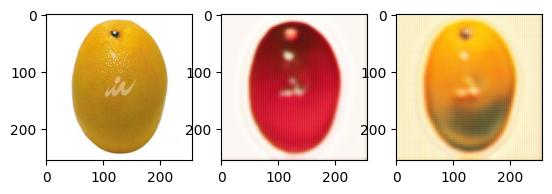

In [ ]:
from PIL import Image
for i, (image1, image2) in enumerate(train_loader):
  if i==9:
    break
image2=image2.to(device)
x=image2[2]
y=gen1(image2)
z=gen2(y)
img_3=z[2].to("cpu").detach().numpy()
img_2=y[2].to("cpu").detach().numpy()
img_1=x.to("cpu").detach().numpy()
# img_1=np.reshape(img_1, newshape=[256, 256, 3])
# img_2=np.reshape(img_2, newshape=[256, 256, 3])
img_1 = np.transpose(img_1, (1, 2, 0))
img_2 = np.transpose(img_2, (1, 2, 0))
img_3 = np.transpose(img_3, (1, 2, 0))
plt.subplot(1,3,1)
plt.imshow(img_1)
plt.subplot(1,3,2)
plt.imshow(img_2)
plt.subplot(1,3,3)
plt.imshow(img_3)
plt.show()